In [ ]:
#Install required packages
%pip install -U langgraph langchain_community langchain_openai langsmith langgraph-swarm 

In [2]:
# Environment Variable Initialization

import getpass
import os

def _set_if_undefined(var_name: str):
    """
    Set an environment variable if it is not already defined.
    
    Args:
        var_name (str): Name of the environment variable to set.
    """
    if not os.environ.get(var_name):
        # Securely prompt the user for input without echoing it on screen
        os.environ[var_name] = getpass.getpass(f"Please provide your {var_name}: ")

# ---- Environment Variables Required ----

_set_if_undefined("OPENAI_API_KEY")         # API key for OpenAI models
_set_if_undefined("LANGSMITH_TRACING")      # Enable LangSmith tracing ("true" to enable)
_set_if_undefined("LANGSMITH_API_KEY")      # API key for LangSmith platform
_set_if_undefined("MODEL")                  # Model name (e.g., "gpt-4.1" "gpt-4o", "gpt-3.5-turbo")

In [3]:
# Human-in-the-Loop Workflow with LangGraph:
#- An AI writer drafts social media articles.
#- A human reviews and either approves, edits, or rejects the draft.
#- An AI reviewer updates articles based on human feedback.
#- The process integrates interrupt/resume points for human validation at key stages.

# ---- Imports ----

import uuid
import os
from typing import Literal, TypedDict
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command
from langchain_core.messages import HumanMessage
from IPython.display import display, Image

# ---- LLM Setup ----

# Load the default model from environment variables
default_model = os.environ["MODEL"]

# Initialize the LLM interface
llm = ChatOpenAI(model=default_model)

# ---- State Definition ----

class State(TypedDict):
    """Graph state for article creation, review, and publishing."""
    topic: str
    article: str
    feedback: str

# ---- Node Definitions ----

def human_review_node(state: State) -> Command[Literal["publisher_node", "reviewer_node", END]]:
    """
    Interrupt the flow to request human feedback on the article.
    Possible human actions: feedback, publish, update, delete.
    """
    human_review = interrupt({
        "ask": (
            "Please provide feedback (example: {'action': 'feedback', 'data': 'reduce size'}) "
            "Possible actions: [feedback, publish, update, delete]"
        ),
        "article_to_review": state["article"]
    })

    review_action = human_review["action"]
    review_data = human_review.get("data")

    if review_action == "delete":
        return Command(goto=END)
    elif review_action == "publish":
        return Command(goto="publisher_node")
    elif review_action == "update":
        return Command(goto="publisher_node", update={"article": review_data})
    elif review_action == "feedback":
        return Command(goto="reviewer_node", update={"feedback": review_data})

    return Command(goto=END)

# Writer agent prompt
writer_system_prompt = (
    "You are a helpful AI assistant collaborating with other assistants. "
    "Your task is to write a short (max 50 words) social media article on the given topic."
)

def writer_node(state: State) -> Command[Literal["human_review_node"]]:
    """
    Generate a first draft of the article.
    """
    messages = [
        {"role": "system", "content": writer_system_prompt},
        {"role": "user", "content": state["topic"]},
    ]
    response = llm.invoke(messages)

    return Command(
        goto="human_review_node",
        update={"article": response.content},
    )

# Reviewer agent prompt
reviewer_system_prompt = (
    "You are a helpful AI assistant collaborating with others. "
    "Your task is to review and update an article based on the given human feedback: "
)

def reviewer_node(state: State) -> Command[Literal["human_review_node"]]:
    """
    Update the article based on human feedback.
    """
    messages = [
        {"role": "system", "content": reviewer_system_prompt + state["feedback"]},
        {"role": "user", "content": state["article"]},
    ]
    response = llm.invoke(messages)
    
    print("Reviewed article:")
    print(response.content)

    return Command(
        goto="human_review_node",
        update={
            "article": response.content,
            "feedback": ""  # Clear feedback after update
        }
    )

def publisher_node(state: State) -> Command[END]:
    """
    Publish the final version of the article.
    """
    print("Published article:")
    print(state["article"])

    return Command(goto=END)
    


In [4]:
# ---- Graph Assembly ----

# Build the state graph
graph_builder = StateGraph(State)
graph_builder.add_node("human_review_node", human_review_node)
graph_builder.add_node("writer_node", writer_node)
graph_builder.add_node("publisher_node", publisher_node)
graph_builder.add_node("reviewer_node", reviewer_node)

# Define flow: Start at writer node
graph_builder.add_edge(START, "writer_node")

# Use MemorySaver as checkpointer (required for human interrupt/resume)
checkpointer = MemorySaver()

# Compile the graph
graph = graph_builder.compile(checkpointer=checkpointer)


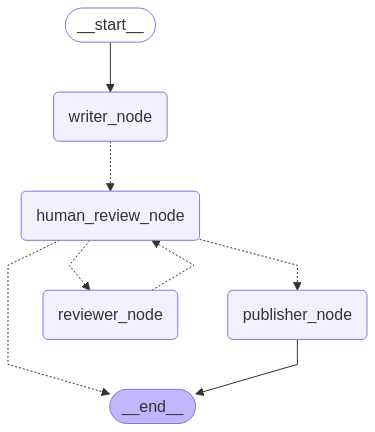

In [5]:
# ---- Visualization ----

# Display the graph using Mermaid visualization
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# ---- Execution ----

# Assign a thread ID for the session
thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

# Initial run: Write an article and wait for human review
for chunk in graph.stream({"topic": "AI Agents"}, config=thread_config, debug=True):
    print(chunk)
    print("============================")

# Pending execution after human interruption
print("********* Pending Human Action *************")
print(graph.get_state(thread_config).next)

# Resume: Human gives feedback to "add emojis"
for chunk in graph.stream(
    Command(resume={"action": "feedback", "data": "add emojis"}),
    config=thread_config,
    debug=True
):
    print(chunk)
    print("============================")

# Pending execution after AI reviewer updates article
print("********* Pending Human Action *************")
print(graph.get_state(thread_config).next)

# Resume: Human approves publication
for chunk in graph.stream(
    Command(resume={"action": "publish"}),
    config=thread_config,
    debug=True
):
    print(chunk)
    print("============================")

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'topic': 'AI Agents'}
[0:writes] Finished step 0 with writes to 1 channel:
- topic -> 'AI Agents'
[0:checkpoint] State at the end of step 0:
{'topic': 'AI Agents'}
[1:tasks] Starting 1 task for step 1:
- writer_node -> {'topic': 'AI Agents'}
[1:writes] Finished step 1 with writes to 1 channel:
- article -> ('AI agents are revolutionizing how we work and connect—handling tasks, '
 'providing insights, and automating processes. From customer support to '
 'creative design, these digital assistants boost efficiency and innovation '
 'across industries, empowering people to focus on what truly matters. '
 'Discover how AI agents are shaping the future!')
[1:checkpoint] State at the end of step 1:
{'article': 'AI agents are revolutionizing how we work and connect—handling '
            'tasks, providing insights, and automating processes. From '
            'customer support to creative des